In [29]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dropout, Lambda, MaxPooling2D, concatenate, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
import tensorflow as tf

# Set some parameters
IMG_WIDTH = 256 # for faster computing on kaggle
IMG_HEIGHT = 256 # for faster computing on kaggle
IMG_CHANNELS = 1
TRAIN_PATH = './train_png/'
MASK_PATH  = './train_mask'
BATCH_SIZE = 32
# TEST_PATH = '../input/stage1_test/'

train_ids = os.listdir(TRAIN_PATH)

# X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for i, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    n = i
    
    path = TRAIN_PATH + id_
    img = imread(path)
    
    img = img.reshape(img.shape[0], img.shape[1], -1)
    
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    X_train[n] = img

    mask = imread(os.path.join(MASK_PATH, id_[:-4] + ".tif"))
    mask = mask.reshape(mask.shape[0], mask.shape[1], -1)
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)

    Y_train[n] = mask


Getting and resizing train images and masks ... 


100%|██████████| 437/437 [00:04<00:00, 95.62it/s] 


In [30]:
X_train.shape

(437, 256, 256, 1)

In [31]:
Y_train.shape

(437, 256, 256, 1)

In [32]:
from tensorflow.keras.preprocessing import image

seed = 42
np.random.seed(seed)

# Creating the training Image and Mask generator
image_datagen = image.ImageDataGenerator(shear_range=0.05, rotation_range=0.2, zoom_range=0.05, width_shift_range=0.05, height_shift_range=0.05, fill_mode='reflect')
mask_datagen = image.ImageDataGenerator(shear_range=0.05, rotation_range=0.2, zoom_range=0.05, width_shift_range=0.05, height_shift_range=0.05, fill_mode='reflect')

# Keep the same seed for image and mask generators so they fit together

image_datagen.fit(X_train[:int(X_train.shape[0]*0.9)], augment=True, seed=seed)
mask_datagen.fit(Y_train[:int(Y_train.shape[0]*0.9)], augment=True, seed=seed)

x = image_datagen.flow(X_train[:int(X_train.shape[0]*0.9)],batch_size=BATCH_SIZE, shuffle=True, seed=seed)
y = mask_datagen.flow(Y_train[:int(Y_train.shape[0]*0.9)],batch_size=BATCH_SIZE, shuffle=True, seed=seed)

# Creating the validation Image and Mask generator
image_datagen_val = image.ImageDataGenerator()
mask_datagen_val = image.ImageDataGenerator()

image_datagen_val.fit(X_train[int(X_train.shape[0]*0.9):], augment=True, seed=seed)
mask_datagen_val.fit(Y_train[int(Y_train.shape[0]*0.9):], augment=True, seed=seed)

x_val = image_datagen_val.flow(X_train[int(X_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y_val = mask_datagen_val.flow(Y_train[int(Y_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)

#creating a training and validation generator that generate masks and images
train_generator = zip(x, y)
val_generator = zip(x_val, y_val)

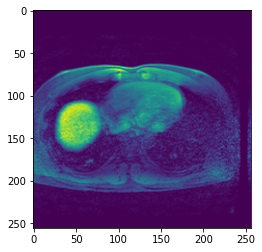

In [33]:
import matplotlib.pyplot as plt
plt.imshow(x[0][0].reshape((256, 256)))
plt.show()

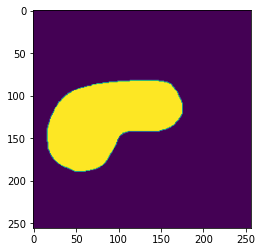

In [34]:
plt.imshow(y[0][0].reshape((256, 256)))
plt.show()

In [49]:
# def unet(pretrained_weights = None,input_size = (256,256,1)):

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
merge6 = concatenate([drop4,up6], axis = 3)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

model = Model(inputs=[inputs], outputs=[conv10])
# model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.compile(optimizer='adam', loss='mse', metrics=['accuracy', tf.keras.metrics.Precision()])

model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_192 (Conv2D)             (None, 256, 256, 64) 640         input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_193 (Conv2D)             (None, 256, 256, 64) 36928       conv2d_192[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_32 (MaxPooling2D) (None, 128, 128, 64) 0           conv2d_193[0][0]                 
____________________________________________________________________________________________

In [50]:
# Fit model
earlystop_callback = EarlyStopping(patience=10, verbose=1)
checkpoint_path = os.path.join("training_checkpoints")
checkpoint_perfix = os.path.join(checkpoint_path, "ckpt_{epoch}")
checkpoint_callback = ModelCheckpoint(
            filepath=checkpoint_perfix, save_weights_only=True, save_best_only=True
        )
results = model.fit_generator(train_generator, validation_data=val_generator, validation_steps=10, steps_per_epoch=250,
                              epochs=1, callbacks=[earlystop_callback, checkpoint_callback])

118/250 [=============>................] - ETA: 1:31 - loss: 0.1322 - accuracy: 0.8636 - precision_1: 0.0658

KeyboardInterrupt: 

In [37]:
pred = model.predict(x[0])

In [38]:
pred[0][0]

array([[0.43985558],
       [0.43985558],
       [0.43985558],
       [0.43985558],
       [0.43985558],
       [0.43985558],
       [0.43985558],
       [0.43985558],
       [0.43985558],
       [0.43985558],
       [0.43985558],
       [0.43985558],
       [0.43985558],
       [0.43985558],
       [0.43985558],
       [0.43985558],
       [0.43985558],
       [0.43985558],
       [0.43985558],
       [0.43985558],
       [0.43985558],
       [0.43985558],
       [0.43985558],
       [0.43985558],
       [0.43985558],
       [0.43985558],
       [0.43985558],
       [0.43985558],
       [0.43985558],
       [0.43985558],
       [0.43985558],
       [0.43985558],
       [0.43985558],
       [0.43985558],
       [0.43985558],
       [0.43985558],
       [0.43985558],
       [0.43985558],
       [0.43985558],
       [0.43985558],
       [0.43985558],
       [0.43985558],
       [0.43985558],
       [0.43985558],
       [0.43985558],
       [0.43985558],
       [0.43985558],
       [0.439